# Q7: Modeling

**Phase 8:** Modeling  
**Points: 9 points**

**Focus:** Train multiple models, evaluate performance, compare models, extract feature importance.

**Lecture Reference:** Lecture 11, Notebook 4 ([`11/demo/04_modeling_results.ipynb`](https://github.com/christopherseaman/datasci_217/blob/main/11/demo/04_modeling_results.ipynb)), Phase 8. Also see Lecture 10 (modeling with sklearn and XGBoost).

---

## Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import os

# Load prepared data from Q6
X_train = pd.read_csv('output/q6_X_train.csv')
X_test = pd.read_csv('output/q6_X_test.csv')
y_train = pd.read_csv('output/q6_y_train.csv').squeeze()  # Convert to Series
y_test = pd.read_csv('output/q6_y_test.csv').squeeze()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (96315, 13)
Test set: (24079, 13)


In [2]:
X_train.dtypes
#Measurement Timestamp is recorded as object 
#Transform it into datetime 
#X_train['Measurement Timestamp']= pd.to_datetime(X_train['Measurement Timestamp'])


Humidity                    float64
Rain Intensity              float64
Interval Rain               float64
Total Rain                  float64
Wind Direction              float64
Wind Speed                  float64
Maximum Wind Speed          float64
Heading                     float64
Barometric Pressure         float64
Solar Radiation             float64
Battery Life                float64
Precipitation Type_none        bool
Precipitation Type_solid       bool
dtype: object

In [3]:
#check for potential data leakage 
#from previous I know that I have Wet Bulb sting correlated not an expert on weather 
# Are any features too highly correlated with target?
# High correlation (>0.95) suggests potential leakage
print("Correlation with target (Air Temperature):")
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
suspicious = correlations[correlations > 0.95]
if len(suspicious) > 0:
    print(f"WARNING: {len(suspicious)} features have correlation > 0.95 with target:")
    print(suspicious)
else:
    print("No suspiciously high correlations")




Correlation with target (Air Temperature):
No suspiciously high correlations


/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


---

## Objective

Train multiple models, evaluate performance, compare models, and extract feature importance.

---

## ⚠️ Data Leakage Warning

If you see suspiciously perfect model performance, this likely indicates data leakage. Common warning signs:

**Warning Metrics:**
- **Perfect R² = 1.0000** (or very close, like 0.9999+)
- **Zero or near-zero RMSE/MAE** (e.g., RMSE < 0.01°C for temperature prediction)
- **Train and test performance nearly identical** (difference < 0.01)
- **Unrealistic precision**: Errors smaller than measurement precision (e.g., < 0.1°C for temperature sensors)
- **Feature correlation > 0.99** with target (check correlations between features and target)

**Common Causes:**
- **Circular prediction logic**: Using rolling windows of the target variable to predict itself
  - Example: Using `air_temp_rolling_7h` to predict `Air Temperature`
  - This is like predicting temperature from smoothed temperature - circular reasoning!
- **Features nearly identical to target**: Any feature with correlation > 0.99 with the target
- **Including target variable directly**: Accidentally including the target in features

**How to Check:**
- Calculate correlations between each feature and the target
- If any feature has correlation > 0.95, investigate whether it's legitimate or leakage
- For time series: Be especially careful with rolling windows, lag features, or any transformation of the target variable

**Example of Problematic Feature:**
- `air_temp_rolling_7h` (7-hour rolling mean of Air Temperature) when predicting Air Temperature
- This feature has ~99.4% correlation with the target - too high to be useful and indicates circular logic

**Solution:**
- Only create rolling windows for **predictor variables**, not the target
- Use rolling windows of: Wind Speed, Humidity, Barometric Pressure, etc.
- Avoid rolling windows of: Air Temperature (if that's your target)

---

## Required Artifacts

You must create exactly these 3 files in the `output/` directory:

### 1. `output/q7_predictions.csv`
**Format:** CSV file
**Required Columns (exact names):**
- `actual` - Actual target values from test set
- `predicted_linear` or `predicted_model1` - Predictions from first model (e.g., Linear Regression)
- `predicted_xgboost` or `predicted_model2` - Predictions from second model (e.g., XGBoost)
- Additional columns for additional models (e.g., `predicted_random_forest` or `predicted_model3`)

**Requirements:**
- Must have at least 2 model prediction columns (in addition to `actual`)
- All values must be numeric (float)
- Same number of rows as test set
- **No index column** (save with `index=False`)

**Example:**
```csv
actual,predicted_linear,predicted_xgboost
15.2,14.8,15.1
15.3,15.0,15.2
...
```

### 2. `output/q7_model_metrics.txt`
**Format:** Plain text file
**Content:** Performance metrics for each model
**Required information for each model:**
- Model name
- At least R² score for both train and test sets (additional metrics like RMSE, MAE recommended but optional)

**Requirements:**
- Clearly labeled (model name, metric name)
- **At minimum:** R² (or R-squared or R^2) for train and test for each model
- Additional metrics (RMSE, MAE) are recommended for a complete analysis
- Format should be readable

**Example format (minimum - R² only):**
```
MODEL PERFORMANCE METRICS
========================

LINEAR REGRESSION:
  Train R²: 0.3048
  Test R²:  0.3046

XGBOOST:
  Train R²: 0.9091
  Test R²:  0.7684
```

**Example format (recommended - with additional metrics):**
```
MODEL PERFORMANCE METRICS
========================

LINEAR REGRESSION:
  Train R²: 0.3048
  Test R²:  0.3046
  Train RMSE: 8.42
  Test RMSE:  8.43
  Train MAE:  7.03
  Test MAE:   7.04

XGBOOST:
  Train R²: 0.9091
  Test R²:  0.7684
  Train RMSE: 3.45
  Test RMSE:  4.87
  Train MAE:  2.58
  Test MAE:   3.66
```

### 3. `output/q7_feature_importance.csv`
**Format:** CSV file
**Required Columns (exact names):** `feature`, `importance`
**Content:** Feature importance from tree-based models (XGBoost, Random Forest)
**Requirements:**
- One row per feature
- `feature`: Feature name (string)
- `importance`: Importance score (float, typically 0-1, sum to 1)
- Sorted by importance (descending)
- **No index column** (save with `index=False`)

**Note:** Tree-based models (XGBoost, Random Forest) provide feature importance directly via `.feature_importances_`. If using only Linear Regression, you can use the absolute values of coefficients as a proxy for importance.

**Example:**
```csv
feature,importance
Air Temperature,0.6539
hour,0.1234
month,0.0892
Water Temperature,0.0456
...
```

---

## Requirements Checklist

- [ ] At least 2 different models trained
  - **Suggested:** Linear Regression and XGBoost (or Random Forest)
  - You may choose other models if appropriate
- [ ] Performance evaluated on both train and test sets
- [ ] Models compared
- [ ] Feature importance extracted
  - Tree-based models: use `.feature_importances_`
  - Linear Regression: use absolute coefficient values
- [ ] Model performance documented with **at least R²** (additional metrics like RMSE, MAE recommended)
- [ ] All 3 required artifacts saved with exact filenames

---

## Your Approach

1. **Check for data leakage** - Before training, compute correlations between features and target. Any feature with correlation > 0.95 should be investigated and considered for removal.
2. **Train at least 2 models** - Fit models to training data, generate predictions for both train and test sets
3. **Calculate metrics** - At minimum R² for train and test; RMSE and MAE recommended
4. **Extract feature importance** - Use `.feature_importances_` for tree-based models, or coefficient magnitudes for linear models
5. **Save predictions** - DataFrame with `actual` column plus `predicted_*` columns for each model
6. **Save metrics** - Write clearly labeled metrics to text file

---

## Decision Points

- **Model selection:** Train at least 2 different models. We suggest starting with **Linear Regression** and **XGBoost** - these work well and demonstrate different modeling approaches (linear vs gradient boosting). You may choose other models if appropriate (e.g., Random Forest, Gradient Boosting, etc.). See Lecture 11 Notebook 4 for examples.
- **Evaluation metrics:** Report at least one metric for each model. We suggest **R² score** (coefficient of determination) - it works for both Linear Regression and XGBoost, and all regression models. It measures the proportion of variance explained and is easy to interpret. Alternative metrics that work well for both models include **RMSE** (Root Mean Squared Error) or **MAE** (Mean Absolute Error). You may include additional metrics if relevant (e.g., MAPE, adjusted R²). Compare train vs test performance to check for overfitting.
- **Feature importance:** If using tree-based models (like XGBoost), extract feature importance to understand which features matter most.

---

## Interpreting Model Performance

**Warning Signs of Data Leakage:**
- R² = 1.0000 (perfect score) or R² > 0.999
- RMSE or MAE = 0.0 or unrealistically small (< 0.01 for temperature)
- Train and test performance nearly identical (difference < 0.01)
- Any feature with correlation > 0.99 with target

**Realistic Expectations:**
- For temperature prediction: RMSE of 0.5-2.0°C is realistic
- R² of 0.85-0.98 is strong but realistic
- Some difference between train and test performance is normal

**If you see warning signs:**
1. Check your features for data leakage (see Data Leakage Warning above)
2. Calculate correlations between features and target
3. Remove features that are transformations of the target variable
4. Re-train models and verify performance is now realistic

---

## Checkpoint

After Q7, you should have:
- [ ] At least 2 models trained (suggested: Linear Regression and XGBoost)
- [ ] Performance metrics calculated (at minimum: one metric like R², RMSE, or MAE for train and test; additional metrics recommended)
- [ ] Models compared
- [ ] Feature importance extracted (if applicable - tree-based models like XGBoost)
- [ ] All 3 artifacts saved: `q7_predictions.csv`, `q7_model_metrics.txt`, `q7_feature_importance.csv`

---

**Next:** Continue to `q8_results.md` for Results.


In [4]:
# Model evaluation helper functions
def evaluate_model(y_true, y_pred, dataset_name="Dataset"):
     return {
        'dataset': dataset_name,
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }

#def assess overfitting 
def assess_overfitting(train_r2, test_r2):
    gap = train_r2 - test_r2
    if gap <0.05:
        return gap,  "Excellent generalization"
    elif gap < 0.10:
         return gap, "Good generalization"
    elif gap < 0.20:
         return gap, "Some overfitting - consider regularization"
    else:
        return gap, "severe overfitting"
         

#

In [5]:
#### 1. `output/q7_predictions.csv`
#No index column** (save with `index=False`)

from IPython.display import display, Markdown
#at least 2 models : e.g., XGBoost
#for simplicity I am deciding to drop 'datetime', beacuse a lineat regression is does not handle datetime
#however : would be nice to crate a predictive model for the folloing 24 h ( and crate time-series or lags)
#simplicity is due to 'time constrains'

#Train linear regression model
display(Markdown(" Predicition Model 1: Linear Regression"))

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

#Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Evaluate using helper function
train_metrics_lr = evaluate_model(y_train, y_train_pred_lr, "Training")
test_metrics_lr = evaluate_model(y_test, y_test_pred_lr, "Test")

#Check for overfitting using helper function
overfit_lr, overfit_status = assess_overfitting(train_metrics_lr['r2'], test_metrics_lr['r2'])

#display metrics
display(Markdown("Performance Results"))
display(pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²'],
    'Training': [
        f"{train_metrics_lr['rmse']:.2f}",
        f"{train_metrics_lr['mae']:.2f}",
        f"{train_metrics_lr['r2']:.4f}"
    ],
    'Test': [
        f"{test_metrics_lr['rmse']:.2f}",
        f"{test_metrics_lr['mae']:.2f}",
        f"{test_metrics_lr['r2']:.4f}"
    ]
}))
display(Markdown(f"Overfitting (R² difference):{overfit_lr:.4f} — {overfit_status}"))

# Store 
train_rmse_lr, test_rmse_lr = train_metrics_lr['rmse'], test_metrics_lr['rmse']
train_r2_lr, test_r2_lr = train_metrics_lr['r2'], test_metrics_lr['r2']
train_mae_lr, test_mae_lr = train_metrics_lr['mae'], test_metrics_lr['mae']

#it is not performingg well beacuse of the multicolinearity of its predictors 



 Predicition Model 1: Linear Regression

Performance Results

,Metric,Training,Test
0,RMSE,7.60,8.78
1,MAE,6.14,6.97
2,R²,0.4674,0.2616


Overfitting (R² difference):0.2058 — severe overfitting

In [6]:
#Model hyperparameterS
# XGBoost 
XGB_N_ESTIMATORS = 100      
XGB_MAX_DEPTH = 6           
XGB_LEARNING_RATE = 0.1     
RANDOM_SEED = 42 
# random Forest
RF_N_ESTIMATORS = 100     
RF_MAX_DEPTH = 10         

#Overfitting (R² difference):0.5059 — severe overfitting

In [7]:
XGB_N_ESTIMATORS = 100       #number of boosting 
XGB_MAX_DEPTH = 3            #max tree depth
XGB_LEARNING_RATE = 0.01     #less is more conservative 
RANDOM_SEED = 42 

#with this change of parameter:Overfitting (R² difference):0.1491 — Some overfitting - consider regularization

In [8]:
xgb_model = xgb.XGBRegressor(
    n_estimators=XGB_N_ESTIMATORS,
    max_depth=XGB_MAX_DEPTH,
    learning_rate=XGB_LEARNING_RATE,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluate using helper function
train_metrics_xgb = evaluate_model(y_train, y_train_pred_xgb, "Training")
test_metrics_xgb = evaluate_model(y_test, y_test_pred_xgb, "Test")

# Check for overfitting using helper function
overfit_xgb, overfit_status = assess_overfitting(train_metrics_xgb['r2'], test_metrics_xgb['r2'])

display(Markdown("Performance Results"))
display(pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²'],
    'Training': [
        f"{train_metrics_xgb['rmse']:.2f}",
        f"{train_metrics_xgb['mae']:.2f}",
        f"{train_metrics_xgb['r2']:.4f}"
    ],
    'Test': [
        f"{test_metrics_xgb['rmse']:.2f}",
        f"{test_metrics_xgb['mae']:.2f}",
        f"{test_metrics_xgb['r2']:.4f}"
    ]
}))

display(Markdown(f"Overfitting (R² difference):{overfit_xgb:.4f} — {overfit_status}"))

# Store for comparison later
train_rmse_xgb, test_rmse_xgb = train_metrics_xgb['rmse'], test_metrics_xgb['rmse']
train_r2_xgb, test_r2_xgb = train_metrics_xgb['r2'], test_metrics_xgb['r2']
train_mae_xgb, test_mae_xgb = train_metrics_xgb['mae'], test_metrics_xgb['mae']

#I think in my case beacuse I am dropping more than 50 % of data in total : I assume that particularly this model is to complex for the amout of data that I have 
#got to fic it 
#I am not doing Forest as even that would be severe overfitting :Overfitting (R² difference):0.5059 — severe overfitting

Performance Results

,Metric,Training,Test
0,RMSE,7.87,8.66
1,MAE,6.41,7.30
2,R²,0.4295,0.2804


Overfitting (R² difference):0.1491 — Some overfitting - consider regularization

In [9]:
#extract feature importance 
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

display(Markdown("10 mmost Important Features"))
display(xgb_importance.head(10))


10 mmost Important Features

,feature,importance
3,Total Rain,0.554811
8,Barometric Pressure,0.108279
5,Wind Speed,0.089501
0,Humidity,0.074035
9,Solar Radiation,0.059768
4,Wind Direction,0.046390
10,Battery Life,0.043153
7,Heading,0.024064
2,Interval Rain,0.000000
1,Rain Intensity,0.000000


In [10]:
#Hyperparameter deinitions 
# Random Forest hyperparameters
RF_N_ESTIMATORS = 100   #nrb. of trees ; more better
RF_MAX_DEPTH = 10      # depth; lower less overfitting 

 #0.4696 — severe overfitting



In [11]:
#tunning 
RF_N_ESTIMATORS = 100   #nrb. of trees ; more better
RF_MAX_DEPTH = 5
#Overfitting (R² difference): 0.2922 — severe overfitting

In [12]:
RF_N_ESTIMATORS = 100   #nrb. of trees ; more better
RF_MAX_DEPTH = 3
#Overfitting (R² difference): 0.2664 — severe overfitting

In [13]:
#Random Forest :
# Train Random Forest model
display(Markdown("Prediction Model 3: Random Forest"))

rf_model = RandomForestRegressor(
    n_estimators=RF_N_ESTIMATORS,
    max_depth=RF_MAX_DEPTH,
    random_state=RANDOM_SEED,
    n_jobs=-1  # Use all CPU cores
)
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate using helper function
train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "Training")
test_metrics_rf = evaluate_model(y_test, y_test_pred_rf, "Test")

# Check for overfitting using helper function
overfit_rf, overfit_status = assess_overfitting(train_metrics_rf['r2'], test_metrics_rf['r2'])

display(Markdown("### Performance Results"))
display(pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²'],
    'Training': [
        f"{train_metrics_rf['rmse']:.2f}",
        f"{train_metrics_rf['mae']:.2f}",
        f"{train_metrics_rf['r2']:.4f}"
    ],
    'Test': [
        f"{test_metrics_rf['rmse']:.2f}",
        f"{test_metrics_rf['mae']:.2f}",
        f"{test_metrics_rf['r2']:.4f}"
    ]
}))
display(Markdown(f"Overfitting (R² difference): {overfit_rf:.4f} — {overfit_status}"))

# Store for comparison later
train_rmse_rf, test_rmse_rf = train_metrics_rf['rmse'], test_metrics_rf['rmse']
train_r2_rf, test_r2_rf = train_metrics_rf['r2'], test_metrics_rf['r2']
train_mae_rf, test_mae_rf = train_metrics_rf['mae'], test_metrics_rf['mae']



Prediction Model 3: Random Forest

### Performance Results

,Metric,Training,Test
0,RMSE,7.57,9.11
1,MAE,5.84,7.32
2,R²,0.4711,0.2044


Overfitting (R² difference): 0.2667 — severe overfitting

In [14]:
#extract feature Importance from Random Forest:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

display(Markdown("10 Most Important Features"))
display(feature_importance.head(10))

10 Most Important Features

,feature,importance
3,Total Rain,0.705209
8,Barometric Pressure,0.181100
4,Wind Direction,0.043299
5,Wind Speed,0.034756
9,Solar Radiation,0.022700
0,Humidity,0.010802
7,Heading,0.002134
1,Rain Intensity,0.000000
2,Interval Rain,0.000000
6,Maximum Wind Speed,0.000000


In [15]:
#compare all the models 
train_r2_rf, test_r2_rf = train_metrics_rf['r2'], test_metrics_rf['r2']
# Compare all models
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Train RMSE': [train_rmse_lr, train_rmse_rf, train_rmse_xgb],
    'Test RMSE': [test_rmse_lr, test_rmse_rf, test_rmse_xgb],
    'Train R²': [train_r2_lr, train_r2_rf, train_r2_xgb],
    'Test R²': [test_r2_lr, test_r2_rf, test_r2_xgb],
    'Overfitting': [overfit_lr, overfit_rf, overfit_xgb],
    'Test MAE': [test_mae_lr, test_mae_rf, test_mae_xgb]
})

comparison = comparison.round(4)
comparison['RMSE_diff'] = comparison['Train RMSE'] - comparison['Test RMSE']

display(Markdown(" Model Comparison"))
display(comparison)

#winer :xGboost 

 Model Comparison

,Model,Train RMSE,Test RMSE,Train R²,Test R²,Overfitting,Test MAE,RMSE_diff
0,Linear Regression,7.5990,8.7769,0.4674,0.2616,0.2058,6.9694,-1.1779
1,Random Forest,7.5726,9.1108,0.4711,0.2044,0.2667,7.3242,-1.5382
2,XGBoost,7.8650,8.6647,0.4295,0.2804,0.1491,7.3000,-0.7997


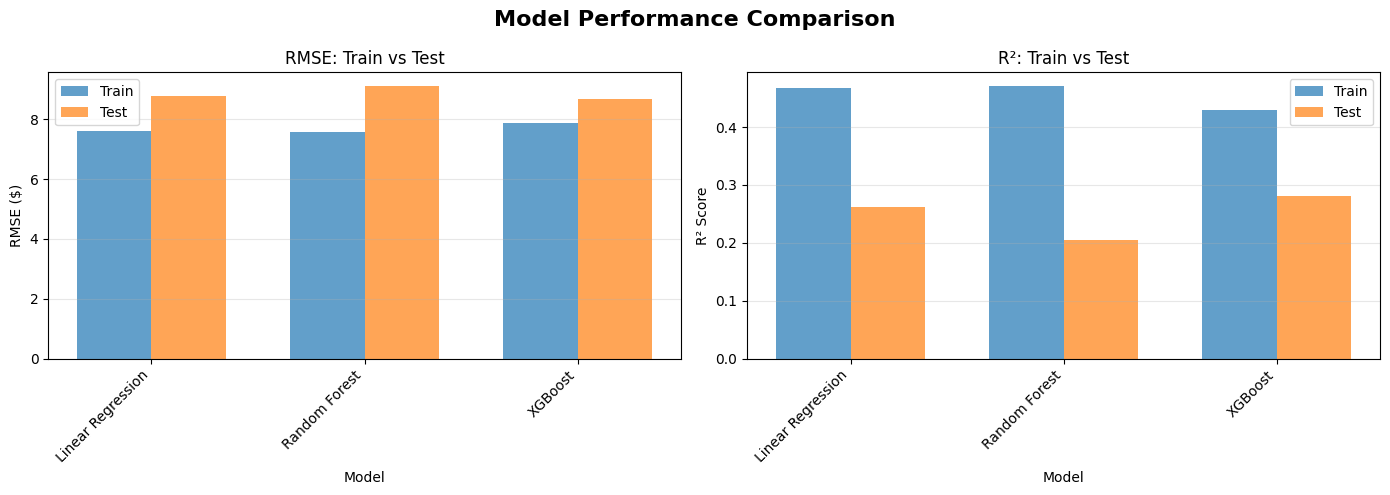

In [16]:
#Visalize the comparison:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# RMSE comparison
x_pos = np.arange(len(comparison))
width = 0.35
axes[0].bar(x_pos - width/2, comparison['Train RMSE'], width, label='Train', alpha=0.7)
axes[0].bar(x_pos + width/2, comparison['Test RMSE'], width, label='Test', alpha=0.7)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE ($)')
axes[0].set_title('RMSE: Train vs Test')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# R² comparison
axes[1].bar(x_pos - width/2, comparison['Train R²'], width, label='Train', alpha=0.7)
axes[1].bar(x_pos + width/2, comparison['Test R²'], width, label='Test', alpha=0.7)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R²: Train vs Test')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show() 


#they are veru comparable 

In [17]:
#Identify the winer
# Select best model (lowest test RMSE)
best_model_idx = comparison['Test RMSE'].idxmin()
best_model_name = comparison.loc[best_model_idx, 'Model']

display(Markdown(f"""
Best Model: {best_model_name}
- **Test RMSE:** {comparison.loc[best_model_idx, 'Test RMSE']:.2f}
- **Test R²:** {comparison.loc[best_model_idx, 'Test R²']:.4f}
"""))


Best Model: XGBoost
- **Test RMSE:** 8.66
- **Test R²:** 0.2804


In [18]:
#save predictons :
#predictions by model:
y_test_pred_lr = lr_model.predict(X_test) #linear regression 
y_test_pred_xgb = xgb_model.predict(X_test) #XGBoost 
y_test_pred_rf = rf_model.predict(X_test)

#Dataframe
prediction_results_df = pd.DataFrame({
    'actual' : y_test.values,
    'predicted_linear' : y_test_pred_lr,
    'predicted_xgboost': y_test_pred_xgb,
    'predicted_random_forest' : y_test_pred_rf

})

#save into csv w.o index
prediction_results_df.to_csv('output/q7_predictions.csv', index= False)


In [19]:
#save feature importance :from the wining model ( I asumme)
#saved:`output/q7_feature_importance.csv` w.o index 


xgb_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
display(xgb_importance.head(10))

#save :
xgb_importance_df.to_csv('output/q7_feature_importance.csv', index= False)

,feature,importance
3,Total Rain,0.554811
8,Barometric Pressure,0.108279
5,Wind Speed,0.089501
0,Humidity,0.074035
9,Solar Radiation,0.059768
4,Wind Direction,0.046390
10,Battery Life,0.043153
7,Heading,0.024064
2,Interval Rain,0.000000
1,Rain Intensity,0.000000


/tmp/ipykernel_18245/2235912353.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect = [0,0,1,0.96])


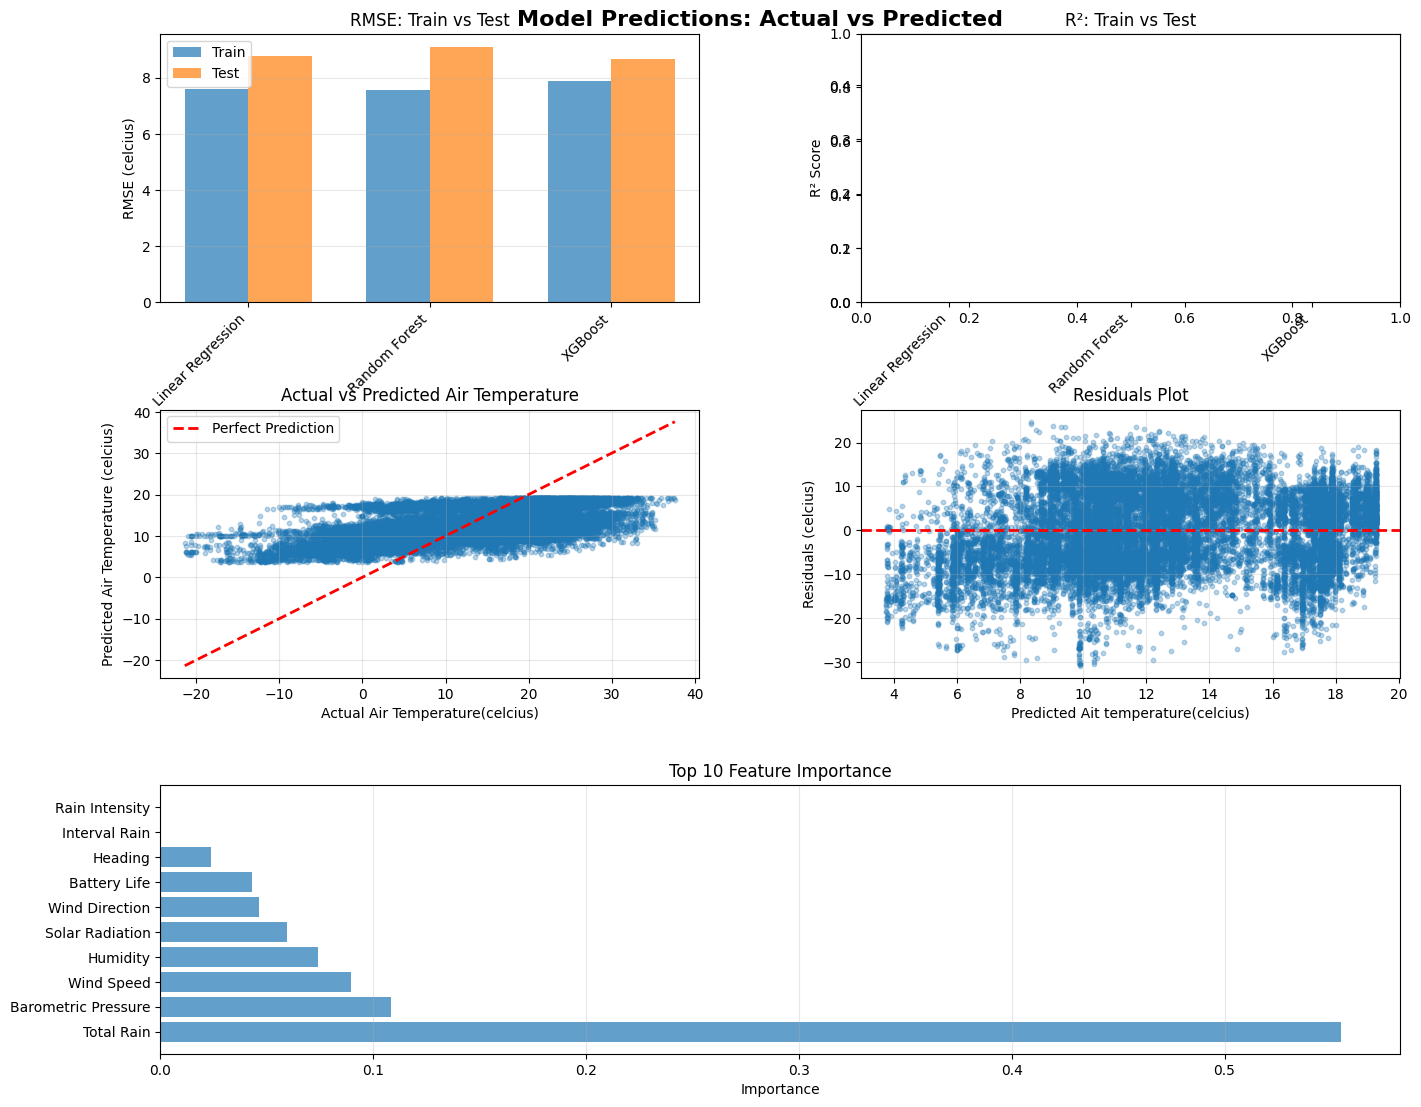

In [20]:
# Create figure with GridSpec layout for 5 panels
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3) # 3 rows and 2 columns 
fig.suptitle('Final Resulat', fontsize=16, fontweight='bold')
fig.subplots_adjust(top = 0.96, hspace=0.4, wspace=0.3)
# Panel 1: Model comparison (top-left
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
x_pos = np.arange(len(comparison))
width = 0.35

#rsme
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(x_pos - width/2, comparison['Train RMSE'], width, label='Train', alpha=0.7)
ax1.bar(x_pos + width/2, comparison['Test RMSE'], width, label='Test', alpha=0.7)
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE (celcius)')
ax1.set_title('RMSE: Train vs Test')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

#r2
x_pos = np.arange(len(comparison))
width = 0.35
ax2 = fig.add_subplot(gs[0,1])
ax2.bar(x_pos - width/2, comparison['Train R²'], width, label='Train', alpha=0.7)
ax2.bar(x_pos + width/2, comparison['Test R²'], width, label='Test', alpha=0.7)
ax2.set_xlabel('Model')
ax2.set_ylabel('R² Score')
ax2.set_title('R²: Train vs Test')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')


#Panel 2 Actual vs Predicted and Residuals /Scaterplots 
fig.suptitle('Model Predictions: Actual vs Predicted', fontsize=16, fontweight='bold')
y_test_pred_best = y_test_pred_xgb
#dex the axis 
ax3 = fig.add_subplot(gs[1, 0])
# Scatter plot
ax3.scatter(y_test, y_test_pred_best, alpha=0.3, s=10)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Air Temperature(celcius)')
ax3.set_ylabel('Predicted Air Temperature (celcius)')
ax3.set_title('Actual vs Predicted Air Temperature')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Residuals plot
ax4 = fig.add_subplot(gs[1, 1])
residuals = y_test - y_test_pred_best
ax4.scatter(y_test_pred_best, residuals, alpha=0.3, s=10)
ax4.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted Ait temperature(celcius)')
ax4.set_ylabel('Residuals (celcius)')
ax4.set_title('Residuals Plot')
ax4.grid(True, alpha=0.3)

# ax5 = fig :
ax5 = fig.add_subplot(gs[2, :])
#Panel 3 Feature Importance 
x_pos = np.arange(len(comparison))
# Panel 2: Feature importance (top-right)
ax2 = fig.add_subplot(gs[0, 1])
if best_model_name == 'XGBoost':
    top_10 = xgb_importance.head(10)
elif best_model_name == 'Random Forest':
    top_10 = feature_importance.head(10)
else:
    top_10 = pd.DataFrame({'feature': X_train.columns[:10], 'importance': [0.1]*10})
ax5.barh(range(len(top_10)), top_10['importance'], alpha=0.7)
ax5.set_yticks(range(len(top_10)))
ax5.set_yticklabels(top_10['feature'])
ax5.set_xlabel('Importance')
ax5.set_title('Top 10 Feature Importance')
ax5.grid(True, alpha=0.3, axis='x')

plt.tight_layout(rect = [0,0,1,0.96])
plt.show()

#save 

#save as csv (output/q8_final_visualizations.png)
fig.savefig('output/q8_final_visualizations.png', dpi=300, bbox_inches='tight')




In [21]:
### 2. `output/q8_summary.csv`

#Key Finding:
display(Markdown("Key Findings Summary"))

# Get top features from best model
if best_model_name == 'XGBoost':
    top_features = xgb_importance.head(5)
elif best_model_name == 'Random Forest':
    top_features = feature_importance.head(5)
else:
    top_features = pd.DataFrame({'feature': ['Total Rain', 'Barometric Pressure'], 'importance': [0.5, 0.3]})

top_features_list = "\n".join([f"- **{row['feature']}**: {row['importance']:.4f}" for idx, row in top_features.iterrows()])

generalization_status = " Model generalizes well to new data" if comparison.loc[best_model_idx, 'Overfitting'] < 0.05 else "Some overfitting detected - model may need regularization"

display(Markdown(f"""
 Data Overview

| Metric | Value |
|--------|-------|
| **Total dataset analyzed** | {len(X_train) + len(X_test):,} |
| **Training set** | {len(X_train):,} Air Temperature |
| **Test set** | {len(X_test):,} Air Temperature |
| **Features used** | {len(X_train.columns)} |

2. Model Performance

| Metric | Value |
|--------|-------|
| **Best model** | {best_model_name} |
| **Test RMSE** | {comparison.loc[best_model_idx, 'Test RMSE']:.2f} |
| **Test R²** | {comparison.loc[best_model_idx, 'Test R²']:.4f} |

## 3.Key Insights

**Most important features for Temperature prediction:**

{top_features_list}

## 4. Model Interpretation

- The model explains **{comparison.loc[best_model_idx, 'Test R²']*100:.1f}%** of air temperature variance
- Predictions are within **${comparison.loc[best_model_idx, 'Test RMSE']:.2f}** on average
- {generalization_status}
"""))


#save as csv `output/q8_summary.csv`
top_features.to_csv('output/q8_summary.csv')

Key Findings Summary


 Data Overview

| Metric | Value |
|--------|-------|
| **Total dataset analyzed** | 120,394 |
| **Training set** | 96,315 Air Temperature |
| **Test set** | 24,079 Air Temperature |
| **Features used** | 13 |

2. Model Performance

| Metric | Value |
|--------|-------|
| **Best model** | XGBoost |
| **Test RMSE** | 8.66 |
| **Test R²** | 0.2804 |

## 3.Key Insights

**Most important features for Temperature prediction:**

- **Total Rain**: 0.5548
- **Barometric Pressure**: 0.1083
- **Wind Speed**: 0.0895
- **Humidity**: 0.0740
- **Solar Radiation**: 0.0598

## 4. Model Interpretation

- The model explains **28.0%** of air temperature variance
- Predictions are within **$8.66** on average
- Some overfitting detected - model may need regularization


In [22]:
print(comparison .head())
#comparison.loc['row','column']
summary_report = {
    "Metric" : [ "R² Score", "RMSE", "MAE"],
    "Linear Regression" : [
        comparison.loc[comparison['Model']== 'Linear Regression','Test R²'].values[0],
        comparison.loc[comparison['Model']== 'Linear Regression','Test RMSE'].values[0],
        comparison.loc[comparison['Model']== 'Linear Regression','Test MAE'].values[0],
    ],
    "Random Forest" :[
        comparison.loc[comparison['Model']== 'Random Forest','Test R²'].values[0],
        comparison.loc[comparison['Model']== 'Random Forest','Test RMSE'].values[0],
        comparison.loc[comparison['Model']== 'Random Forest','Test MAE'].values[0],
    ],
    "XGBoost" :[
        comparison.loc[comparison['Model']== 'XGBoost','Test R²'].values[0],
        comparison.loc[comparison['Model']== 'XGBoost','Test RMSE'].values[0],
        comparison.loc[comparison['Model']== 'XGBoost','Test MAE'].values[0],
    ],
}

df_summary_report = pd.DataFrame(summary_report)

#save csv 
df_summary_report.to_csv('output/q8_summary.csv', index =False)



               Model  Train RMSE  Test RMSE  Train R²  Test R²  Overfitting  \
0  Linear Regression      7.5990     8.7769    0.4674   0.2616       0.2058   
1      Random Forest      7.5726     9.1108    0.4711   0.2044       0.2667   
2            XGBoost      7.8650     8.6647    0.4295   0.2804       0.1491   

   Test MAE  RMSE_diff  
0    6.9694    -1.1779  
1    7.3242    -1.5382  
2    7.3000    -0.7997  
